In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import wget
import json

In [2]:
URL = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json"
PATH = "D:/Code/ML/Sarcasm Dataset/sarcasm.json"

In [3]:
# wget.download(URL, PATH)

In [4]:
with open(PATH, 'r') as f:
    datastore = json.load(f)

sentences = [] 
labels = []
urls = []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

In [5]:
vocab_size = 10000
embedding_dim = 32
max_length = 32
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = 20000

In [6]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [7]:
training_sentences[:3]

["former versace store clerk sues over secret 'black code' for minority shoppers",
 "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
 "mom starting to fear son's web series closest thing she will have to grandchild"]

In [8]:
training_labels[:3]

[0, 0, 1]

In [9]:
testing_sentences[:3]

['pediatricians announce 2011 newborns are ugliest babies in 30 years',
 "don't rely on your fitness tracker to lose weight",
 'you might want to cut back on the soap']

In [10]:
testing_labels[:3]

[1, 0, 0]

In [11]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index
# print(len(word_index))
# print(word_index)
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length,
                                padding=padding_type, truncating=trunc_type)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length,
                                padding=padding_type, truncating=trunc_type)
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length), 
#     tf.keras.layers.GlobalAveragePooling1D(), 
#     tf.keras.layers.Dense(24, activation='relu'), 
#     tf.keras.layers.Dense(1, activation='sigmoid')
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.375),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(
    loss = 'binary_crossentropy', 
    optimizer = 'adam', 
    metrics = ['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 32)            320000    
_________________________________________________________________
dropout (Dropout)            (None, 32, 32)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 28, 64)            10304     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 64)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 7, 128)            98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                4

In [13]:
num_epochs = 30
history = model.fit(
    training_padded, 
    training_labels, 
    epochs=num_epochs, 
    validation_data=(testing_padded, testing_labels), 
    shuffle=True,
    verbose=2
)

Epoch 1/30
625/625 - 12s - loss: 0.6104 - accuracy: 0.6375 - val_loss: 0.4077 - val_accuracy: 0.8077
Epoch 2/30
625/625 - 10s - loss: 0.3996 - accuracy: 0.8387 - val_loss: 0.3748 - val_accuracy: 0.8390
Epoch 3/30
625/625 - 9s - loss: 0.3003 - accuracy: 0.8986 - val_loss: 0.3904 - val_accuracy: 0.8463
Epoch 4/30
625/625 - 8s - loss: 0.2381 - accuracy: 0.9201 - val_loss: 0.4310 - val_accuracy: 0.8548
Epoch 5/30
625/625 - 8s - loss: 0.1934 - accuracy: 0.9399 - val_loss: 0.4373 - val_accuracy: 0.8489
Epoch 6/30
625/625 - 9s - loss: 0.1572 - accuracy: 0.9527 - val_loss: 0.5180 - val_accuracy: 0.8487
Epoch 7/30
625/625 - 9s - loss: 0.1377 - accuracy: 0.9579 - val_loss: 0.5627 - val_accuracy: 0.8425
Epoch 8/30
625/625 - 10s - loss: 0.1232 - accuracy: 0.9628 - val_loss: 0.6390 - val_accuracy: 0.8414
Epoch 9/30
625/625 - 10s - loss: 0.1049 - accuracy: 0.9678 - val_loss: 0.9237 - val_accuracy: 0.8463
Epoch 10/30
625/625 - 10s - loss: 0.1008 - accuracy: 0.9710 - val_loss: 0.7052 - val_accuracy: 0

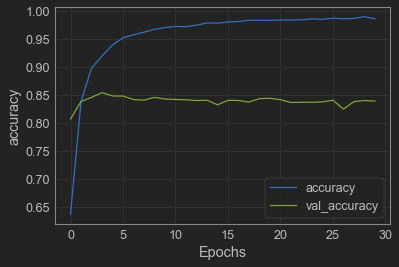

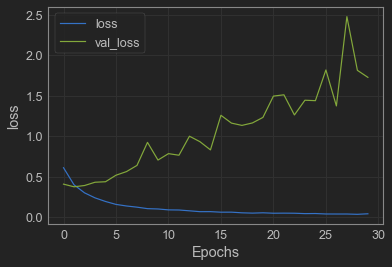

In [14]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [15]:
model.save("saved_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model\assets


In [16]:
loaded_model = tf.keras.models.load_model("saved_model")

In [17]:
model_eval = loaded_model.evaluate(
    testing_padded, 
    testing_labels
)
model_eval

210/210 [==============================] - 1s 5ms/step - loss: 1.7270 - accuracy: 0.8398


[1.7270185947418213, 0.8397674560546875]

In [18]:
headline = "Popular New Podcast Just Mark Ruffalo Reading Names Of Murder Victims"

example_sequence = tokenizer.texts_to_sequences([headline.lower()])
example_padded = pad_sequences(example_sequence, maxlen=max_length,
                                padding=padding_type, truncating=trunc_type)
print(headline)
print(example_sequence)
print(example_padded)

Popular New Podcast Just Mark Ruffalo Reading Names Of Murder Victims
[[1191, 12, 3133, 38, 585, 8481, 1159, 680, 3, 792, 648]]
[[1191   12 3133   38  585 8481 1159  680    3  792  648    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]]


In [19]:
if(np.around(loaded_model.predict(example_padded)).reshape(-1)):
    print("'" + headline + "'" + "\nSarcasm Detected")
else: print("'" + headline + "'" + "\nNo Sarcasm Detected")

'Popular New Podcast Just Mark Ruffalo Reading Names Of Murder Victims'
Sarcasm Detected
